In [9]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Ensure repository code is importable
import sys
from pathlib import Path
repo_root = Path('..').resolve()
sys.path.append(str(repo_root / 'Codes' / 'sourcecode'))

from RC_Optimization import optimize_full_energy_system, build_tariff

In [20]:
# Time axis and tariff
start = pd.Timestamp('2024-01-01')
n_days = 2
step = '30min'
tariff = build_tariff(start, n_days=n_days, step=step, type='cosy')

# Derived quantities
n_steps = len(tariff)
dt_seconds = (tariff.index[1] - tariff.index[0]).total_seconds()
hours = tariff.index.hour + tariff.index.minute / 60.0

# Weather profiles (smooth diurnal cycles)
Tout = 5 + 6 * np.sin(2 * np.pi * (hours - 8) / 24)  # outdoor temperature in °C
S = np.clip(550 * np.sin(np.pi * (hours - 6) / 12), 0, None)  # solar irradiance in W/m²

# Heating set-points
comfort_setpoint = np.where((hours >= 6) & (hours < 9) | (hours >= 17) & (hours < 22), 21.0, 17.0)
flex_setpoint = np.where((hours >= 6) & (hours < 8) | (hours >= 18) & (hours < 21), 20.0, 16.0)
setpoint_sequences = [comfort_setpoint, flex_setpoint]

# Hot water demand from local daily CSV samples (m^3 per time step)
steps_per_day = int(pd.Timedelta('1D') / pd.Timedelta(step))
hw_samples_root = Path('E:\GitHubProjects\LV network\Input data\Hotwater')
hw_scenario = 'crest_hotwater_all_runs_wd_rural.csv'  # update to your scenario name
hw_samples_dir = hw_samples_root / hw_scenario


def _hw_series_from_csv(path, value_column=None):
    df = pd.read_csv(path)
    if value_column and value_column in df.columns:
        series = df[value_column]
    else:
        numeric_cols = [c for c in df.columns if pd.api.types.is_numeric_dtype(df[c])]
        series = df[numeric_cols[0]] if numeric_cols else df.iloc[:, -1]
    return pd.to_numeric(series, errors='coerce').fillna(0).to_numpy()


def sample_hw_from_dir(directory, n_days, steps_per_day, rng, value_column=None):
    directory = Path(directory)
    csv_paths = sorted(p for p in directory.glob('*.csv') if p.is_file())
    if not csv_paths:
        raise FileNotFoundError(f"No CSV files found in {directory}. Point this to your hot water samples.")

    chosen = []
    per_day = []
    for _ in range(n_days):
        idx = int(rng.integers(0, len(csv_paths)))
        path = csv_paths[idx]
        values = _hw_series_from_csv(path, value_column=value_column)
        if len(values) < steps_per_day:
            values = np.pad(values, (0, steps_per_day - len(values)), mode='edge')
        elif len(values) > steps_per_day:
            values = values[:steps_per_day]
        per_day.append(values)
        chosen.append(path.name)

    hw = np.concatenate(per_day)
    return hw, chosen


rng = np.random.default_rng(42)
hw_value_column = None  # set to the column containing hot water draw in m^3 if the CSVs have multiple columns
hw_demand, hw_samples_used = sample_hw_from_dir(hw_samples_dir, n_days, steps_per_day, rng, value_column=hw_value_column)
print(f"Hot water samples ({hw_samples_dir}) used per day: {hw_samples_used}")

# Base electric load (W)
base_electric = 400 * np.ones(n_steps)

# EV availability sampled from truncated normals
dep_mu, dep_sigma = 625, 127.17   # earliest departure (minutes from midnight)
arr_mu, arr_sigma = 1009, 151.36  # latest arrival (minutes from midnight)
mileage_mu, mileage_sigma = 34.78, 24.01  # km
consumption_per_km = 0.2  # kWh/km
ev_capacity_kwh = 80.0


def sample_truncated_normal(mu, sigma, low, high, size=None):
    size = size if size is not None else ()
    sample = rng.normal(mu, sigma, size=size)
    sample = np.clip(sample, low, high)
    return sample


dep_min = float(sample_truncated_normal(dep_mu, dep_sigma, 0, 24 * 60))
arr_min = float(sample_truncated_normal(arr_mu, arr_sigma, 0, 24 * 60))
mileage = float(sample_truncated_normal(mileage_mu, mileage_sigma, 0, 300))

# Build availability mask and travel energy draw profile
ev_availability = np.ones(n_steps)
ev_availability[:] = 1.0
travel_energy_kwh = np.zeros(n_steps)

# Compute departure/arrival indices
minutes = tariff.index.hour * 60 + tariff.index.minute
trip_mask = (minutes >= dep_min) & (minutes < arr_min)
ev_availability[trip_mask] = 0.0

# Distribute mileage over the trip window if it exists
if trip_mask.any():
    trip_indices = np.where(trip_mask)[0]
    energy_per_step = (mileage * consumption_per_km) / len(trip_indices)
    travel_energy_kwh[trip_indices] = energy_per_step

# EV parameters
travel_energy = travel_energy_kwh * 1000  # convert kWh to Wh for consistency

ev_params = {
    'ev_capacity': ev_capacity_kwh * 1000,  # Wh
    'ev_target': 0.5 * ev_capacity_kwh * 1000,
    'ev_charge_max': 11e3,  # W
    'ev_availability': ev_availability,
    'eta_ev_charge': 0.95,
    'travel_energy': travel_energy,
}

     

FileNotFoundError: No CSV files found in E:\GitHubProjects\LV network\Input data\Hotwater\crest_hotwater_all_runs_wd_rural.csv. Point this to your hot water samples.

In [17]:
# Thermal model parameters
params = {
    'R1': 1 / 200,  # K/W
    'C1': 3e7,      # J/K
    'g': 2.0,      # solar gain factor
    'dt': dt_seconds,
    'T0': 20.0,
    'tol': 1.0,
    'COP': 3.5,
    'etaB': 0.9,
    'Qhp_max': 7e3,   # W
    'Qbo_max': 0e3,  # W
}

# Hot water configuration: switch to 'boiler_only' for HHP without storage,
# or keep 'hp_storage' to mimic the mHP case with a cylinder.
hw_params = {
    'hw_mode': 'hp_storage',
    'V_stor': 0.2,       # m^3 storage volume capacity
    'V_stor_init': 0.12, # initial stored volume (m^3)
    'T_mains': 10.0,
    'T_hw_supply': 40.0,
}

results = optimize_full_energy_system(
    tariff=tariff,
    Tout=Tout,
    S=S,
    setpoint_sequences=setpoint_sequences,
    hw_demand=hw_demand,
    base_electric=base_electric,
    day_ahead=True,
    **params,
    **ev_params,
    **hw_params,
)

best_key = results.get('best_key', next(k for k in results if k.startswith('schedule_')))
best = results['best_result']['results'] if 'best_result' in results else results[best_key]['results']
best_cost = results['best_result']['cost'] if 'best_result' in results else results[best_key]['cost']
print(f"Best schedule: {best_key}, total cost = {best_cost:.2f}")

best.head()
     

Best schedule: schedule_1, total cost = 476263.83


,Tin,T_set,T_low,T_high,Q_hp_space,Q_bo_space,Q_hp_hw,Q_bo_hw,T_stor,V_stor,elec_cost,gas_cost,P_ev_charge,ev_soc
2024-01-01 00:00:00,20.000000,16.0,15.0,NaN,0.0,0.0,4.785549e-08,0.0,55.0,0.12,3000.0,0.0,0.0,80.0
2024-01-01 00:30:00,19.757646,16.0,15.0,NaN,0.0,0.0,0.000000e+00,0.0,55.0,0.12,3000.0,0.0,0.0,80.0
2024-01-01 01:00:00,19.514035,16.0,15.0,NaN,0.0,0.0,0.000000e+00,0.0,55.0,0.12,3000.0,0.0,0.0,80.0
2024-01-01 01:30:00,19.270320,16.0,15.0,NaN,0.0,0.0,0.000000e+00,0.0,55.0,0.12,3000.0,0.0,0.0,80.0
2024-01-01 02:00:00,19.027692,16.0,15.0,NaN,0.0,0.0,0.000000e+00,0.0,55.0,0.12,3000.0,0.0,0.0,80.0


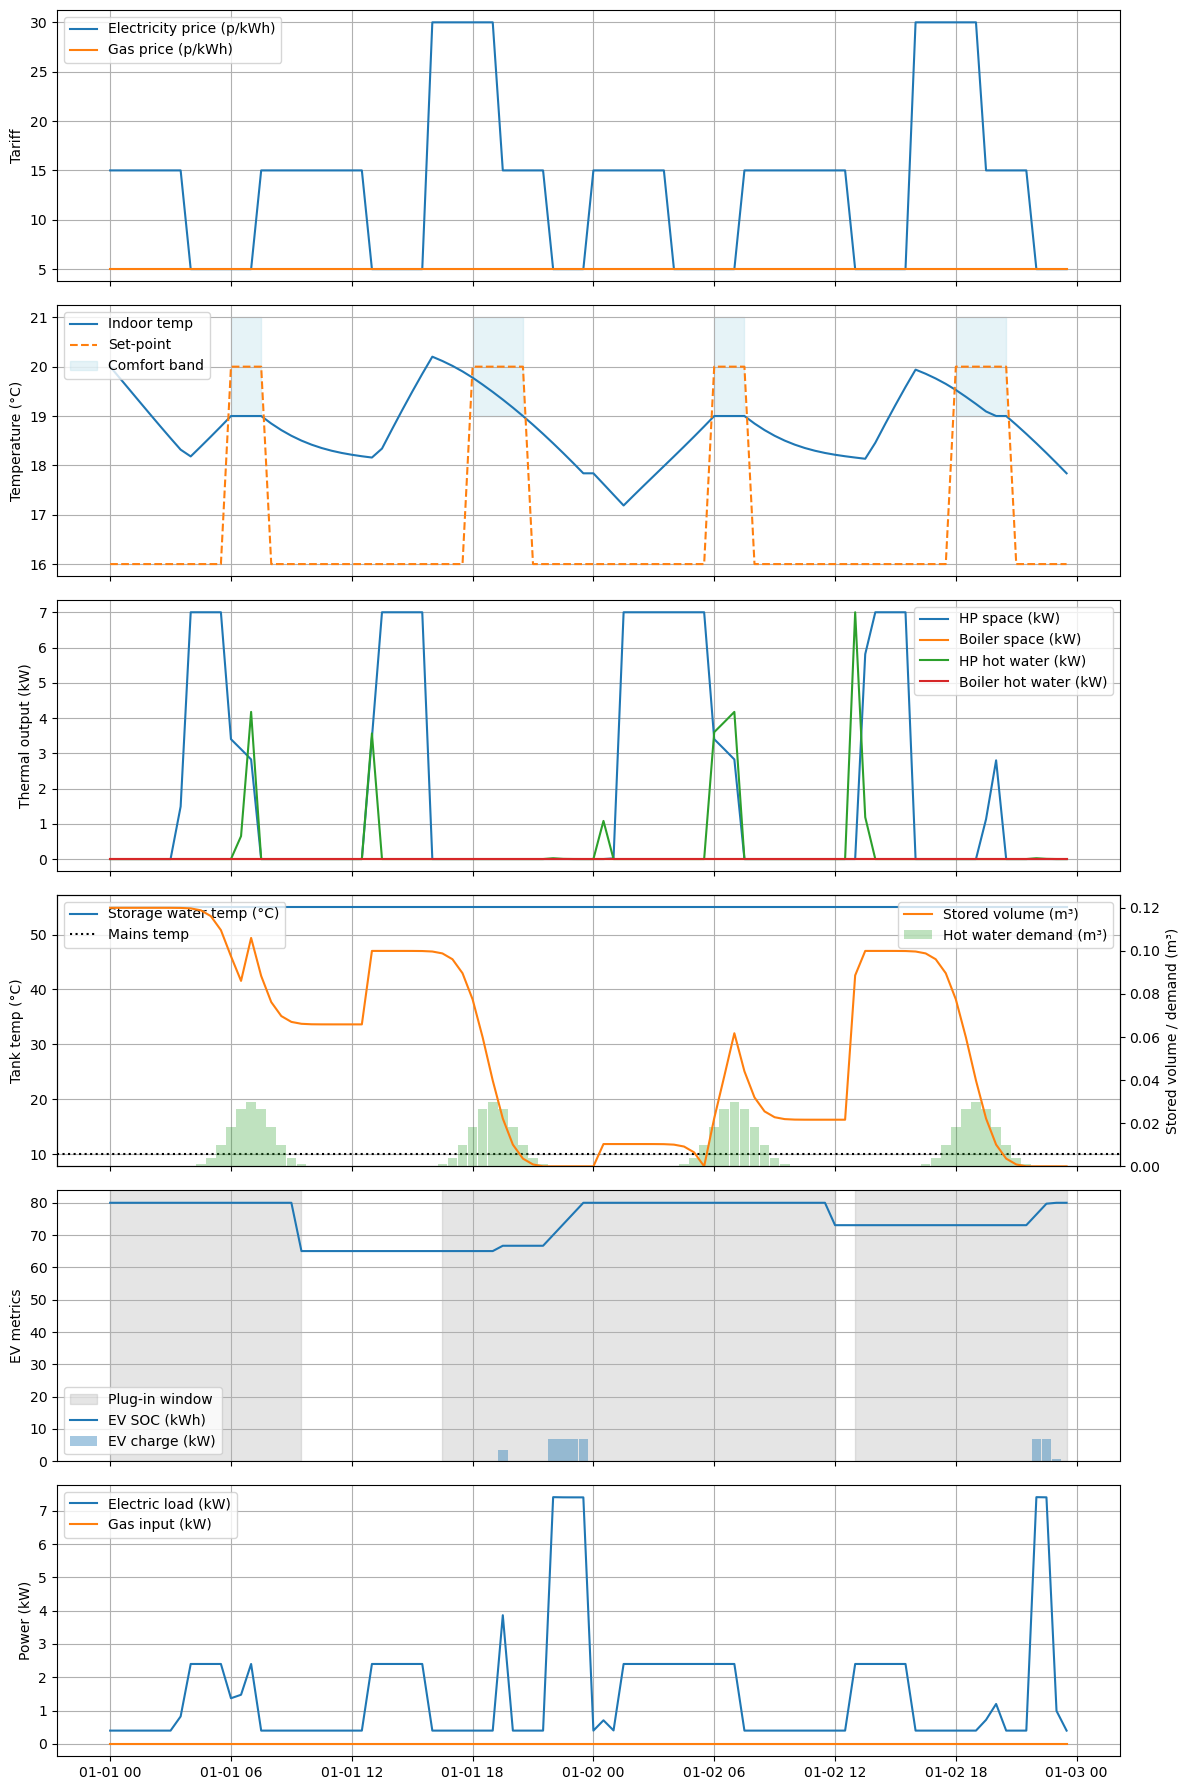

In [18]:
use_storage = np.isfinite(best['T_stor']).any()

n_rows = 6 if use_storage else 5
fig, axs = plt.subplots(n_rows, 1, figsize=(12, 18 if use_storage else 16), sharex=True)

axs[0].plot(tariff.index, tariff['elec_price'], label='Electricity price (p/kWh)')
axs[0].plot(tariff.index, tariff['gas_price'], label='Gas price (p/kWh)')
axs[0].legend(); axs[0].set_ylabel('Tariff'); axs[0].grid(True)

axs[1].plot(best.index, best['Tin'], label='Indoor temp')
axs[1].plot(best.index, best['T_set'], '--', label='Set-point')
axs[1].fill_between(best.index, best['T_low'], best['T_high'], color='lightblue', alpha=0.3, label='Comfort band')
axs[1].legend(); axs[1].set_ylabel('Temperature (°C)'); axs[1].grid(True)

axs[2].plot(best.index, best['Q_hp_space']/1000, label='HP space (kW)')
axs[2].plot(best.index, best['Q_bo_space']/1000, label='Boiler space (kW)')
axs[2].plot(best.index, best['Q_hp_hw']/1000, label='HP hot water (kW)')
axs[2].plot(best.index, best['Q_bo_hw']/1000, label='Boiler hot water (kW)')
axs[2].legend(); axs[2].set_ylabel('Thermal output (kW)'); axs[2].grid(True)

if use_storage:
    tank_ax = axs[3]
    vol_ax = tank_ax.twinx()
    tank_ax.plot(best.index, best['T_stor'], label='Storage water temp (°C)')
    tank_ax.axhline(hw_params.get('T_mains', np.nan), color='k', linestyle=':', label='Mains temp')
    vol_ax.plot(best.index, best['V_stor'], color='tab:orange', label='Stored volume (m³)')
    vol_ax.bar(best.index, hw_demand, width=0.02, alpha=0.3, color='tab:green', label='Hot water demand (m³)')
    tank_ax.legend(loc='upper left'); vol_ax.legend(loc='upper right')
    tank_ax.set_ylabel('Tank temp (°C)')
    vol_ax.set_ylabel('Stored volume / demand (m³)')
    tank_ax.grid(True)

ev_ax = axs[3] if not use_storage else axs[4]
plugin_series = pd.Series(ev_params['ev_availability'], index=best.index)
plugged = plugin_series > 0.5
if plugged.any():
    spans = []
    start = None
    for ts, avail in plugged.items():
        if avail and start is None:
            start = ts
        elif not avail and start is not None:
            spans.append((start, ts))
            start = None
    if start is not None:
        spans.append((start, plugin_series.index[-1]))
    for i, (s, e) in enumerate(spans):
        ev_ax.axvspan(s, e, color='gray', alpha=0.2, label='Plug-in window' if i == 0 else None)

ev_ax.plot(best.index, best['ev_soc'], label='EV SOC (kWh)')
ev_ax.bar(best.index, best['P_ev_charge'], width=0.02, alpha=0.4, label='EV charge (kW)')
ev_ax.legend(); ev_ax.set_ylabel('EV metrics'); ev_ax.grid(True)

# Aggregate consumption
heat_pump_elec = (best['Q_hp_space'] + best['Q_hp_hw']) / params['COP'] / 1000  # kW
other_elec = base_electric / 1000  # kW
ev_elec = best['P_ev_charge']  # already kW
gas_input = (best['Q_bo_space'] + best['Q_bo_hw']) / params['etaB'] / 1000  # kW (thermal -> fuel)

agg_ax = axs[4] if not use_storage else axs[5]
agg_ax.plot(best.index, heat_pump_elec + other_elec + ev_elec, label='Electric load (kW)')
agg_ax.plot(best.index, gas_input, label='Gas input (kW)')
agg_ax.legend(); agg_ax.set_ylabel('Power (kW)'); agg_ax.grid(True)

plt.xlabel('Time')
plt.tight_layout()
plt.show()

     